## Tratamento dos dados

#### Importação das bibliotecas

In [55]:
import pandas as pd
import os
from graph_tool import Graph, stats, spectral
from netpixi.data.gt import *
import netpixi
import cpnet
import seaborn as sns
from math import sqrt
from matplotlib import rcParams
import statsmodels.formula.api as smf
import numpy as np

#### Ligas disponíveis

O dataset de transferências possui os dados das seguintes ligas:

#### Problemas:

- Sub21 e Sub18
DATA_DIR = './data/transfers_master/data'- Incoerência entre as colunas club_name e club_involved_name

In [19]:
DATA_DIR = './data/transfers_master/data'
os.listdir(DATA_DIR + '/' + '2014')

['spanish_primera_division.csv',
 'dutch_eredivisie.csv',
 'portugese_liga_nos.csv',
 'french_ligue_1.csv',
 'italian_serie_a.csv',
 'russian_premier_liga.csv',
 'english_premier_league.csv',
 'english_championship.csv',
 'german_bundesliga_1.csv']

#### Loading Data

Função para carregar o dataset. Recebe o diretório que o data está salvo e o ano.

In [20]:
def loading_data(DATA_DIR, year):
    
    # Leitura do primeiro dataset para carregar as columns
    dir = "./data/transfers_master/data/"+ year + "/dutch_eredivisie.csv"
    data = pd.read_csv(dir)

    # Loop desconsidera o primeiro elemento (carregado no código acima)
    for league in os.listdir(DATA_DIR + '/' + year)[1:]:
            string = (DATA_DIR + '/' + year + '/' + league)
            data_temp = pd.read_csv(string)
            
            # Concatenação dos dados
            data = pd.concat([data, data_temp])
     
    return(data)

def concat_year(start, end, DATA_DIR, data):
    
    for year in range(start, end+1):
        data = pd.concat([data, loading_data(DATA_DIR, str(year))])
        
    return data

In [21]:
DATA_DIR = './data/transfers_master/data'
YEAR = '1992'

data = loading_data(DATA_DIR, YEAR)
data

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,Fortuna Sittard,René Hofman,31.0,Right Winger,Roda JC,?,in,Summer,NaN,Eredivisie,1992,1992/1993
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,Summer,NaN,Eredivisie,1992,1992/1993
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,Summer,NaN,Eredivisie,1992,1992/1993
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,Summer,0.00,Eredivisie,1992,1992/1993
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,Summer,0.00,Eredivisie,1992,1992/1993
...,...,...,...,...,...,...,...,...,...,...,...,...
271,1.FC Nuremberg,Percy Olivares,24.0,Left-Back,Sport. Cristal,Free transfer,out,Winter,0.00,1 Bundesliga,1992,1992/1993
272,1. FC Köln,Andrzej Kobylanski,22.0,Left Midfield,Siarka T.,£270Th.,in,Winter,0.27,1 Bundesliga,1992,1992/1993
273,1.FC Kaiserslautern,Bernhard Winkler,26.0,Centre-Forward,SC Fortuna Köln,Loan,out,Winter,0.00,1 Bundesliga,1992,1992/1993
274,SG Dynamo Dresden,Nikica Maglica,27.0,Forward,NK Zagreb,?,in,Winter,NaN,1 Bundesliga,1992,1992/1993


In [22]:
data = concat_year(1993, 2015, DATA_DIR, data)

In [23]:
data_in = data.loc[data["transfer_movement"] == "in"]
data_out = data.loc[data["transfer_movement"] == "out"]
data_in = data_in.reset_index()
data_out = data_out.reset_index()

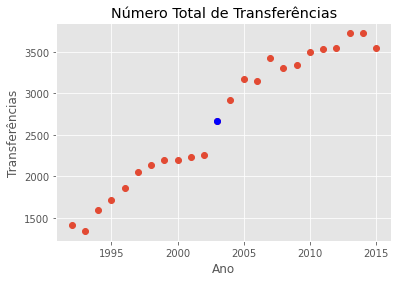

In [24]:
import matplotlib.pyplot as plt

pl = data_in["year"].value_counts()
pre_gal = pl.sort_index()
pos_gal = pl.sort_index()
pre_gal = pre_gal[:11]
pos_gal = pos_gal[11:]

plt.style.use('ggplot')
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.plot(pl.sort_index(), 'o', label = "Transferências")
plt.plot(2003 ,pl[2003], 'bo', label = "Era");

## Pré-Galácticos e Pós-Galacticos

O gráfico acima mostra a evolução no número de transferências de jogadores ao longo dos anos, dessa forma pode-se perceber que 2003 foi o ano em que houve a maior evolução no número de movimentações no mercado do futebol europeu da história. Portanto, deixou-se essa data como destaque em azul no gráfico, marcando o fim da era dos galácticos e o começo da era pós galácticos.

Assim, como o segundo gráfico mostra os anos em rosa que indicam a era pré-galácticos e os em azul a era pós-galácticos. 

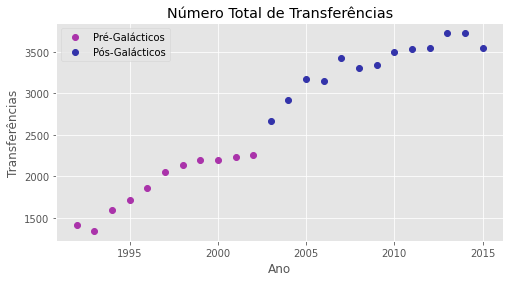

In [25]:
plt.figure(figsize = (8,4))
plt.plot(pre_gal, 'o', label = "Pré-Galácticos", color = "#AA33AA")
plt.plot(pos_gal, 'o', label = "Pós-Galácticos", color = "#3333AA")
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.legend(loc="upper left")
plt.show()

In [26]:
in_names = list(data_in["club_name"].value_counts().index)
out_names = list(data_in["club_involved_name"].value_counts().index)
name_dic = {}
problems = ["Olympique Marseille", "Olympique Lyon", "Eintracht Braunschweig", "Eintracht Frankfurt"]
for in_str in in_names:
    for out_str in out_names:

        if out_str[:10] in in_str and out_str != in_str:
            if (out_str not in problems) or (in_str not in problems):
#                 print(in_str ,", ", out_str)
                name_dic[out_str] = in_str

In [27]:
for k,v in name_dic.items():
    data_in["club_involved_name"].replace({k: v}, inplace=True)
    
data_in

,index,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,0,Fortuna Sittard,René Hofman,31.0,Right Winger,Roda JC Kerkrade,?,in,Summer,NaN,Eredivisie,1992,1992/1993
1,1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,Summer,NaN,Eredivisie,1992,1992/1993
2,2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,Summer,NaN,Eredivisie,1992,1992/1993
3,3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,Summer,0.00,Eredivisie,1992,1992/1993
4,8,Dordrecht'90,Michel Langerak,23.0,Attacking Midfield,VVV-Venlo,?,in,Summer,NaN,Eredivisie,1992,1992/1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64570,562,Hamburger SV,Josip Drmic,23.0,Centre-Forward,Bor. M'gladbach,Loan fee:£1.08m,in,Winter,1.08,1 Bundesliga,2015,2015/2016
64571,563,Hamburger SV,Nabil Bahoui,24.0,Left Winger,Ahli,Free transfer,in,Winter,0.00,1 Bundesliga,2015,2015/2016
64572,564,Hamburger SV,Dren Feka,18.0,Defensive Midfield,Hamburger SV,-,in,Winter,0.00,1 Bundesliga,2015,2015/2016
64573,568,FC Ingolstadt 04,Darío Lezcano,25.0,Centre-Forward,FC Luzern,£2.25m,in,Winter,2.25,1 Bundesliga,2015,2015/2016


In [28]:
data_in["year"].value_counts()

2013    3726
2014    3724
2012    3554
2015    3547
2011    3541
2010    3494
2007    3428
2009    3343
2008    3305
2005    3175
2006    3154
2004    2926
2003    2663
2002    2256
2001    2240
2000    2194
1999    2193
1998    2137
1997    2051
1996    1857
1995    1718
1994    1593
1992    1413
1993    1343
Name: year, dtype: int64

In [29]:
data_pre_gal = data_in[data_in["year"] <= 2003]
data_pos_gal =  data_in[data_in["year"] > 2003]

In [30]:
g2 = Graph(directed=True) # dirigido
g2.vp['name'] = g2.new_vp('object')
g2.vp['league'] = g2.new_vp('object')
g2.ep["transfer"] = g2.new_ep('object')

In [31]:
times = []
for index, rows in data_pos_gal.iterrows():
    time1 = rows[1]
    time2 = rows[5]
    if time1 not in times:
        times.append(time1)
        g2.add_vertex()
        v_time = g2.vertex(times.index(time1))
        g2.vp['name'][v_time] = time1
        g2.vp['league'][v_time] = rows[10]
        
    if time2 not in times:
        times.append(time2)
        g2.add_vertex()
        v_time = g2.vertex(times.index(time2))
        g2.vp['name'][v_time] = time2
        g2.vp['league'][v_time] = rows[10]
    
    index1 = times.index(time1)
    index2 = times.index(time2)
    
    if g2.edge(index1, index2) == None:
        g2.add_edge(index1, index2)
        e = g2.edge(index1, index2)
        g2.ep["transfer"][e] = 1
    else:
        e = g2.edge(index1, index2)
        g2.ep["transfer"][e] = g2.ep["transfer"][e] + 1

In [32]:
stats.remove_self_loops(g2)
m = draw_gt.sfdp_layout(g2)
move_gt(g2, m)
save_gt(g2, 'exemplo3.net.gz')

In [33]:
data_in["league_name"].value_counts()

Championship      12342
Eredivisie        11216
Premier League     9652
Serie A            7532
Liga Nos           7382
Ligue 1            6365
1 Bundesliga       5163
Premier Liga       4923
Name: league_name, dtype: int64

In [34]:
g2 = load_gt('exemplo3.net.gz')

g2.vp['color'] = g2.new_vp('object')

for v in g2.vertices():
    if g2.vp['league'][v] == "Premier League":
        g2.vp['color'][v] = 0x0000ff
        
    if g2.vp['league'][v] == "Eredivisie":
        g2.vp['color'][v] = 0x00ff00
        
    if g2.vp['league'][v] == "Championship":
        g2.vp['color'][v] = 0x0000f0
        
    if g2.vp['league'][v] == "Serie A":
        g2.vp['color'][v] = 0xff00ff
        
    if g2.vp['league'][v] == "Liga Nos":
        g2.vp['color'][v] = 0xff0000
        
    if g2.vp['league'][v] == "Ligue 1":
        g2.vp['color'][v] = 0xffff00
        
    if g2.vp['league'][v] == "1 Bundesliga":
        g2.vp['color'][v] = 0x1100ff
        
    if g2.vp['league'][v] == "Premier Liga":
        g2.vp['color'][v] = 0x00ffff

m = draw_gt.sfdp_layout(g2)
move_gt(g2, m)
save_gt(g2, 'exemplo4.net.gz')
# r = netpixi.render('exemplo4.net.gz')

In [35]:
def centro_periferia(g, t):
    matrix = spectral.adjacency(g)
    if t == "core":
        algorithm = cpnet.LowRankCore()
    elif t == "coreness":
        algorithm = cpnet.MINRES()

    algorithm.detect(matrix)
    c = algorithm.get_coreness()

    g.vp[t] = g.new_vp('object')
    for i, coreness in c.items():
        v = g.vertex(i)
        g.vp[t][v] = float(coreness)

In [36]:
centro_periferia(g2, "core")

In [37]:
df = pd.DataFrame({k: list(v) for k, v in g2.vp.items()})
df.head()

,id,name,league,_x,_y,color,core
0,0,Ajax Amsterdam,Eredivisie,0.664999,1.293018,65280,1.0
1,1,Newell's,Eredivisie,0.696042,1.288844,65280,0.0
2,2,SC Heerenveen,Eredivisie,0.660880,1.300220,65280,1.0
3,3,Boca Juniors,Eredivisie,0.688133,1.274611,65280,0.0
4,4,Figueirense FC,Eredivisie,0.654015,1.255910,65280,0.0


In [38]:
df["league"].value_counts()

Liga Nos          609
Premier Liga      357
Championship      351
Serie A           348
Eredivisie        322
Ligue 1           285
Premier League    246
1 Bundesliga      225
Name: league, dtype: int64

In [39]:
def plot_cp(df):
    plt.figure(figsize=(16,8))
    plt.plot(df[df["league"] == "Eredivisie"]["_x"], df[df["league"] == "Eredivisie"]["_y"],
             'o', markersize=12, label = "Eredivisie", alpha=.5)
    plt.plot(df[df["league"] == "Liga Nos"]["_x"], df[df["league"] == "Liga Nos"]["_y"],
             'o', markersize=12, label = "Liga Nos", alpha=.5)
    plt.plot(df[df["league"] == "Premier Liga"]["_x"], df[df["league"] == "Premier Liga"]["_y"],
             'o', markersize=12, label = "Premier Liga", alpha=.5)
    plt.plot(df[df["league"] == "Championship"]["_x"], df[df["league"] == "Championship"]["_y"],
             'o', markersize=12, label = "Championship", alpha=.5)
    plt.plot(df[df["league"] == "Serie A"]["_x"], df[df["league"] == "Serie A"]["_y"],
             'o', markersize=12, label = "Serie A", alpha=.5)
    plt.plot(df[df["league"] == "Ligue 1"]["_x"], df[df["league"] == "Ligue 1"]["_y"],
             'o', markersize=12, label = "Ligue 1", alpha=.5)
    plt.plot(df[df["league"] == "Premier League"]["_x"], df[df["league"] == "Premier League"]["_y"],
             'o', markersize=12, label = "Premier League", alpha=.5)
    plt.plot(df[df["league"] == "1 Bundesliga"]["_x"], df[df["league"] == "1 Bundesliga"]["_y"],
             'o', markersize=12, label = "1 Bundesliga", alpha=.5)
    plt.title("Classificação core & liga")
    plt.xlabel("posição em X")
    plt.ylabel("posição em Y")
    plt.legend(loc = "upper right")
    plt.show()

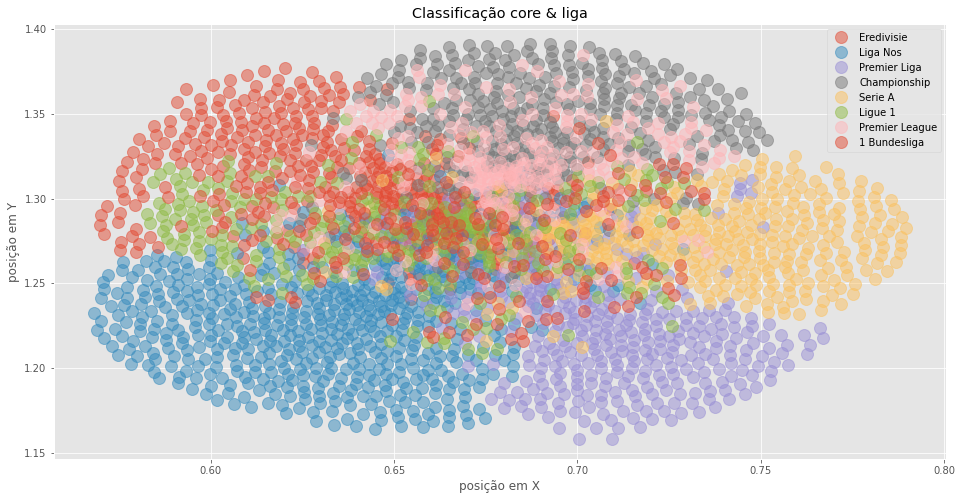

In [40]:
plot_cp(df)

In [72]:
def get_weight(grafo, propriedade):
    l = []
    for u in grafo.vertices():
        i = 0
        for e in u.out_edges():
            i += grafo.ep[propriedade][e]
        l.append(i)
    return l

In [73]:
df["transfer"] = get_weight(g2, "transfer")
df_dicotomizado = df[df["transfer"] > df["transfer"].mean()]
df_dicotomizado

,id,name,league,_x,_y,color,core,transfer
0,0,Ajax Amsterdam,Eredivisie,0.664999,1.293018,65280,1.0,370
2,2,SC Heerenveen,Eredivisie,0.660880,1.300220,65280,1.0,374
7,7,NAC Breda,Eredivisie,0.657478,1.305494,65280,0.0,316
8,8,FC Volendam,Eredivisie,0.637944,1.297976,65280,0.0,20
10,10,NEC Nijmegen,Eredivisie,0.651029,1.308940,65280,0.0,346
...,...,...,...,...,...,...,...,...
2186,2186,FC Évian Thonon Gaillard,Ligue 1,0.674615,1.277371,16776960,0.0,59
2208,2208,Ural Yekaterinburg,Premier Liga,0.711695,1.240846,65535,0.0,80
2215,2215,FK Ufa,Premier Liga,0.686515,1.236341,65535,0.0,48
2257,2257,PEC Zwolle,Eredivisie,0.657277,1.302512,65280,0.0,120


<AxesSubplot:>

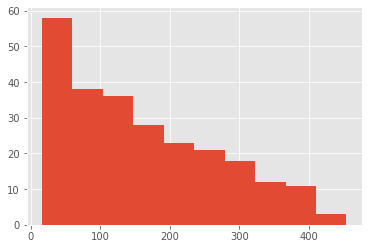

In [76]:
df_dicotomizado["transfer"].hist()

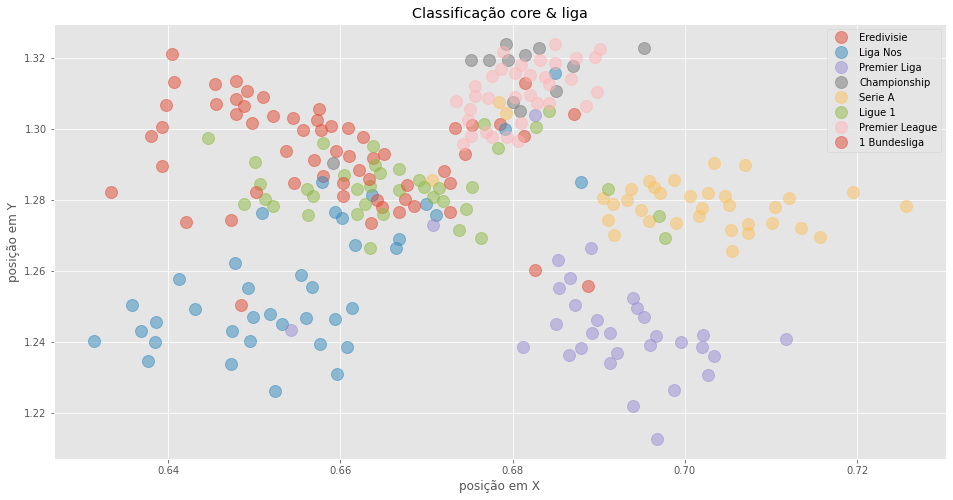

In [74]:
plot_cp(df_dicotomizado)

## Conclusão sobre o grafo das tranferências entre clubes europeus

Observando o grafo plotado, é possível observar panelinhas entre as ligas do futebol europeu, fica bem claro a concentração entre os times de mesma liga quando se olha para as cores e os devidos posicionamentos dos vértices ao longo da rede, assim fica mais evidente a possível existência de times que interligam tranferências entre as ligas, os quais corroboram para a hipótese do grupo.

**Hipótese: Times com boa relação com times de diferentes ligas (relacionamento interliga) atingem melhor desempenho na champions league**


In [41]:
def loading_champions_data(DATA_DIR, year, end):
    list_df = []
    str_year = f"{year}-{str(year+1)[-2:]}"
    dir = "./data/champions_league/"+ str_year + "/champs.csv"
    data = pd.read_csv(dir)
    list_df.append(data)
    start = year + 1
    
    for year in range(start, end+1):
        str_year = f"{year}-{str(year+1)[-2:]}"
        dir = "./data/champions_league/"+ str_year + "/champs.csv"
        
        #data = pd.concat([data, pd.read_csv(dir)])
        data = pd.read_csv(dir)
        list_df.append(data)
    return(list_df)

In [42]:
DATA_DIR = './data/champions_league'
YEAR = 1992

list_df = loading_champions_data(DATA_DIR, YEAR, 2015)
list_df[1]

,Stage,Round,Group,Date,Team 1,FT,HT,Team 2,∑FT,ET,P,Comments
0,NaN,Prelim. Round | Leg 1,NaN,(Wed) 18 Aug 1993 (W33),Skonto › LVA (1),0-1,0-0,Olimpija Ljubljana › SVN (1),NaN,NaN,NaN,NaN
1,NaN,Prelim. Round | Leg 1,NaN,(Wed) 18 Aug 1993 (W33),Cwmbran Town › WAL (1),3-2,0-0,Cork City › IRL (1),NaN,NaN,NaN,NaN
2,NaN,Prelim. Round | Leg 1,NaN,(Wed) 18 Aug 1993 (W33),Avenir Beggen › LUX (1),0-2,0-0,Rosenborg BK › NOR (1),NaN,NaN,NaN,NaN
3,NaN,Prelim. Round | Leg 1,NaN,(Wed) 18 Aug 1993 (W33),B68 Toftir › FRO (1),0-5,0-0,Dinamo Zagreb › CRO (1),NaN,NaN,NaN,NaN
4,NaN,Prelim. Round | Leg 1,NaN,(Wed) 18 Aug 1993 (W33),Zimbru Chisinau › MDA (1),1-1,0-0,Beitar Jerusalem › ISR (1),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
90,Group,Matchday ?,B,(Wed) 13 Apr 1994 (W15),FC Porto › POR (10),0-0,0-0,AC Milan › ITA (10),NaN,NaN,NaN,NaN
91,Group,Matchday ?,B,(Wed) 13 Apr 1994 (W15),RSC Anderlecht › BEL (10),1-2,1-1,Werder Bremen › GER (10),NaN,NaN,NaN,NaN
92,NaN,Semifinals,NaN,(Wed) 27 Apr 1994 (W17),FC Barcelona › ESP (11),3-0,2-0,FC Porto › POR (11),NaN,NaN,NaN,NaN
93,NaN,Semifinals,NaN,(Wed) 27 Apr 1994 (W17),AC Milan › ITA (11),3-0,1-0,AS Monaco › FRA (11),NaN,NaN,NaN,NaN


In [43]:
# dict_teams = {}
# for df in list_df:
    